<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Non-linear-Regression" data-toc-modified-id="Non-linear-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Non-linear Regression</a></span></li><li><span><a href="#Automatic-Differentiation" data-toc-modified-id="Automatic-Differentiation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Automatic Differentiation</a></span></li><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient Descent</a></span><ul class="toc-item"><li><span><a href="#Discussion:-What-happens-if-we-change-the-parameters-of-the-steepest-descent-algorithm-(initial-guess,-number-of-steps,-step-size)?" data-toc-modified-id="Discussion:-What-happens-if-we-change-the-parameters-of-the-steepest-descent-algorithm-(initial-guess,-number-of-steps,-step-size)?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discussion: What happens if we change the parameters of the steepest descent algorithm (initial guess, number of steps, step size)?</a></span></li></ul></li><li><span><a href="#Optimization-with-Scipy" data-toc-modified-id="Optimization-with-Scipy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimization with Scipy</a></span><ul class="toc-item"><li><span><a href="#Discussion:-How-would-you-create-a-loss-function-that-ensures-that-all-weights-$w_i$-are-positive?" data-toc-modified-id="Discussion:-How-would-you-create-a-loss-function-that-ensures-that-all-weights-$w_i$-are-positive?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Discussion: How would you create a loss function that ensures that all weights $w_i$ are positive?</a></span></li></ul></li></ul></div>

# Numerical Optimization

In this lecture we will continue to work with the ethanol peaks dataset and look at numerical optimization from the perspective of non-linear regression.

First, we can re-load the dataset and select the same region we were working on before:

Text(0,0.5,'absorbance')

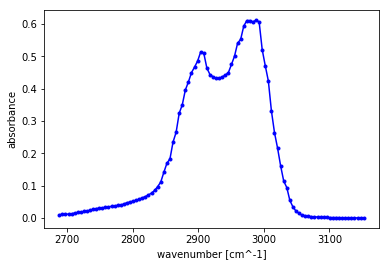

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak,y_peak, '-b', marker='.')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance')

## Non-linear Regression

In the prior lecture we considered "general linear models" that followed the form:

$y_i = \sum_j w_j X_{ij} + \epsilon_i$

and all non-linear behavior has been captured by using non-linear transforms of $x_i$. However, in some cases we may want to optimize models that are not linear. For example, consider the Gaussian peak problem:

$y_i = w_0 \exp\left(-\frac{(x_i-\mu_0)^2}{2(\sigma_0^2)}\right) + w_1 \exp\left(-\frac{(x_i-\mu_1)^2}{2(\sigma_1^2)}\right) + \epsilon_i$

Previously we just guessed values for $\mu_i$ and $\sigma_i$. However, it would be better if we could determine them from the data. Let's go back to the derivation of the linear regression equations. Remember that our goal is to minimize the sum of squared errors:

$g = \sum_i \epsilon_i^2$

We can solve for $\epsilon_i$ from the model:

$\epsilon_i = y_i - w_0 \exp\left(-\frac{(x_i-\mu_0)^2}{2(\sigma_0^2)}\right) - w_1 \exp\left(-\frac{(x_i-\mu_1)^2}{2(\sigma_1^2)}\right) = y_i - \sum_j w_j G(x_i, \mu_j, \sigma_j)$

where $G(x_i, \mu_j, \sigma_j) = \exp\left(-\frac{(x_i-\mu_j)^2}{2(\sigma_j^2)}\right)$.

and substitute:

$g = \sum_i (y_i - \sum_j w_j G(x_i, \mu_j, \sigma_j))^2$

Now our loss function depends on all the parameters, $w_j$, $\mu_j$, and $\sigma_j$!

$g(w_j, \mu_j, \sigma_j) = \sum_i (y_i - \sum_j w_j G(x_i, \mu_j, \sigma_j))^2$

Let's introduce a new vector, $\vec{\lambda}$, that is a vector containing all the parameters:

$\vec{\lambda} = [\vec{w},\; \vec{\mu},\; \vec{\sigma}]$

We can do this since $\lambda_{i\leq m}$ contains the weights, $\lambda_{m < i \leq 2m}$ contains the means, and $\lambda_{i > 2m}$ contains the standard deviations. This is convenient since we can now write:

$g(\lambda_j) = \sum_{i=0}^m (y_i - \sum_j \lambda_j G(x_i, \lambda_{m+j}, \lambda_{2m+j}))^2$

and we can minimize the loss by setting the derivative equal to zero:

$\frac{\partial g}{\partial \lambda_j} = 0$

This may look scary, but we are actually just using multivariate calculus exactly like we did for linear regression. However, we are stuck with two new problems:

(1) Getting the derivative $\frac{\partial g}{\partial \lambda_j}$ will be very complicated.

(2) We need a way to find the point where $\frac{\partial g}{\partial \lambda_j}=0$.

In the case of linear regression, we derived this with matrix algebra then solved the resulting equations but that will be much more difficult in this case, and will not be general to other non-linear forms. Instead, we will use numerical methods this time around.

First, we need to implement our loss function, $g$, which we will call `gaussian_loss` since it results from a sum of $m$ Gaussians:

In [2]:
import numpy as np

def gaussian_loss(lamda, x, y, m=2):
    yhat = np.zeros(len(y))
    for i in range(m):
        beta_i = lamda[i]
        mu_i = lamda[m+i]
        sigma_i = lamda[2*m+i]
        yhat = yhat + beta_i*np.exp(-(x - mu_i)**2/(2*sigma_i**2))
    squared_error = (y - yhat)**2
    return np.sum(squared_error)/len(y)

Let's do a sanity check by generating some data and testing the loss function:

In [3]:
x = np.linspace(-1,1,20)
y = 0.3*np.exp((-(x-0.2)**2)/(2*(0.5**2))) #create a Gaussian with w=0.3, mu=0.2, sigma=0.5
y = y + 0.7*np.exp(-(x-0.5)**2/(2*0.1**2)) #add a Gaussian with w=0.7, mu=0.5, sigma=0.1
lamda = [0.3, 0.7, 0.2, 0.5, 0.5, 0.1] #create a "lamda" vector that should result in the same dataset
test_loss = gaussian_loss(lamda, x, y, m=2)
test_loss

0.0

It looks like our loss function is working properly. Now we need to know how to find the derivative.

## Automatic Differentiation

Derivatives are needed a lot in machine learning. One development that has emerged from the field of computer science is the idea of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), also sometimes called "algorithmic differentiation". This is crucial to the success of well-known machine learning packages like "TensorFlow". The details of how it works are far too advanced for this course, and we will not use it often. However, it is definitely worth knowing about since many engineering applications also require derivatives.

The simple version is that automatic differentiation does exactly what it sounds like: it gives you the derivative of a function automatically! We do need to use some special tools to do this in Python. The `autograd` package is the simplest, since it works well with `numpy`. We also need to write our functions in a specific way so that they only take one argument.

In [4]:
# ! pip install autograd #<- use this block (or the command after ! in the conda prompt) to install autograd

In [5]:
import autograd.numpy as np   # autograd has its own "version" of numpy that must be used
from autograd import grad # the "grad" function provides derivatives

def g(lamda, x=x, y=y, m=2):
    return gaussian_loss(lamda, x, y, m)

diff_g = grad(g)
diff_g

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f>

If you are not familiar with Python, this may look very odd. Essentially we are "wrapping" the `gaussian_loss` function in a new function `g`. Unlike `gaussian_loss`, `g` only takes a single argument, `lamda`, which is the argument we want to differentiate with respect to.

It is also worth noting that the `grad` function returns a function, not a value. This will also feel odd if you are new to Python. However, it is very convenient, because now we can use the new *function* `diff_g` to compute the derivative at any arbitrary value of $\lambda$:

In [6]:
print(diff_g(lamda))

[array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]


This is another sanity check: we know that the derivative should be zero if we are already at the optimum!

Let's try with some other guess for $\lambda_j$:

In [7]:
bad_guess = [0.1, 1.0, 0.5, 0.3, 0.1, 0.4]
print(diff_g(bad_guess))

[array(0.04543042), array(0.32856694), array(-0.01728235), array(-0.09807934), array(0.08818821), array(0.39993077)]


Now we have solved the first problem: we know how to get $\frac{\partial g}{\partial \lambda_j}(\lambda_j)$. However, we do not have an analytical form (i.e. we can't write it down), so we still don't know how to solve for $\frac{\partial g}{\partial \lambda_j} = 0$.

## Gradient Descent

There are many numerical techniques for solving the problem of finding $\vec{\lambda}^*$ such that $\frac{\partial g}{\partial \lambda_j}(\vec{\lambda}^*) = 0$ . The two basic approaches, which should be familiar, are:

* Newton's method: Treat this as a root finding problem and use the second derivative, $\frac{\partial^2 L}{\partial \lambda_j \lambda_k}$ to iteratively optimize.

* Gradient descent/ascent: Increase or decrease the guess by "walking" along the gradient.

These are typically "iterative" methods, which means we start with some initial guess then iteratively improve it. 

The simplest approach is to use gradient descent with a fixed step size, which we will explore here:

In [8]:
better_guess = [0.35, 0.75, 0.21, 0.52, 0.53, 0.11]
guess = bad_guess
print('Initial Loss: {:.4f}'.format(g(guess)))

N_iter = 100
h = 0.5
for i in range(N_iter):
    guess -= h*np.array(diff_g(guess))
    
print('Final Loss: {:.4f}'.format(g(guess)))

Initial Loss: 0.0963
Final Loss: 0.0002


We can see that the loss decreases after 100 iterations of gradient descent. Let's compare the results:

Actual Input: [0.3, 0.7, 0.2, 0.5, 0.5, 0.1]
Regression Result: [0.6355028  0.32864257 0.5004442  0.24882585 0.0974687  0.47892196]


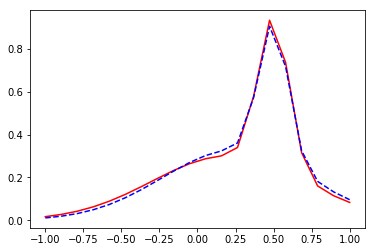

In [9]:
print('Actual Input: {}'.format(str(lamda)))
print('Regression Result: {}'.format(str(guess)))


def two_gaussians(lamda, x):
    beta_0, beta_1, mu_0, mu_1, sigma_0, sigma_1 = lamda
    y = beta_0*np.exp((-(x-mu_0)**2)/(2*(sigma_0**2))) + beta_1*np.exp(-(x-mu_1)**2/(2*sigma_1**2))
    return y

y = two_gaussians(lamda, x)
yhat = two_gaussians(guess, x)

fig, ax = plt.subplots()
ax.plot(x, y, color='r')
ax.plot(x, yhat, color='b', ls='--')

We see that this looks pretty good! The parameters look different, but it turns out that they are pretty close if you switch the order of the two peaks.

### Discussion: What happens if we change the parameters of the steepest descent algorithm (initial guess, number of steps, step size)?

The details of numerical algorithms for multi-dimensional optimization are tricky! However, most optimizers use a form of gradient descent. From now on we will typically let a built-in optimizer handle the hard work!

## Optimization with Scipy

The `scipy` package is another commonly-used package that comes with lots of algorithms. In particular, there are a number of numerical optimization algorithms available through the `scipy.minimize` package. In practice, we will typically rely on `scipy.minimize` to handle minimization rather than writing our own algorithms. These algorithms will be more efficient, and have built-in techniques for estimating derivatives (or manage to optimize without derivatives at all).

One of the most commonly-used algorithms is the ["BFGS" algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm), named after it's creators Broyden, Fletcher, Goldfarb, and Shanno. When in doubt, this is a good algorithm to try first. Let's see how it works for our problem:

In [10]:
from  scipy.optimize  import minimize

result = minimize(g, bad_guess, method='BFGS')
result

      fun: 4.535834086328743e-13
 hess_inv: array([[ 1.08648965e+01, -2.31102013e+00,  8.04786981e-02,
        -4.86071429e+00, -1.20650239e-01,  1.95091675e-01],
       [-2.31102013e+00,  3.48437293e+00,  1.64287106e-01,
         2.27707455e+00, -5.99422521e-01, -2.63840446e+00],
       [ 8.04786981e-02,  1.64287106e-01,  2.64088306e-01,
        -4.39759929e-01, -9.86221948e-03, -4.11746751e-01],
       [-4.86071429e+00,  2.27707455e+00, -4.39759929e-01,
         1.28831480e+01, -1.04319377e+00,  1.39259269e+00],
       [-1.20650239e-01, -5.99422521e-01, -9.86221948e-03,
        -1.04319377e+00,  3.66085479e-01,  2.17736828e-02],
       [ 1.95091675e-01, -2.63840446e+00, -4.11746751e-01,
         1.39259269e+00,  2.17736828e-02,  9.05845978e+00]])
      jac: array([-1.50786322e-07,  2.82043245e-08, -8.94333746e-07, -3.18042594e-07,
       -6.58598643e-07,  7.75125258e-08])
  message: 'Optimization terminated successfully.'
     nfev: 248
      nit: 28
     njev: 31
   status: 0
  succ

A few things to note here:

* We still had to use the function `g` that only takes a single argument (the variable we want to optimize with respect to).

* The output is not a single number, but rather a Python class with various attributes.

We can investigate the attributes of the output using the `dir` function:

In [11]:
dir(result)

['fun',
 'hess_inv',
 'jac',
 'message',
 'nfev',
 'nit',
 'njev',
 'status',
 'success',
 'x']

Now we can check various aspects of the result using the `.` operator:

In [12]:
result.success

True

In [13]:
result.x

array([0.69999993, 0.29999964, 0.49999979, 0.19999771, 0.1000001 ,
       0.50000067])

This tells us that the optimization was successful, and gives us the final result. Let's compare this to the original input:

In [14]:
print('Actual Input: {}'.format(str(result.x)))
print('Regression Result: {}'.format(str(lamda)))

Actual Input: [0.69999993 0.29999964 0.49999979 0.19999771 0.1000001  0.50000067]
Regression Result: [0.3, 0.7, 0.2, 0.5, 0.5, 0.1]


We can see that this was much faster than our naive gradient descent, and is also more accurate (although the order of the peaks is still switched due to the bad initial guess).

Let's revisit the real spectra we worked with earlier and try to optimize the peak positions and widths:

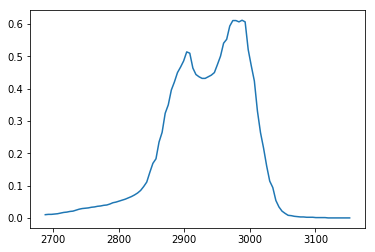

In [15]:
fig, ax = plt.subplots()
ax.plot(x_peak, y_peak)

Remember that we used guesses of the peak position and width:

$y_i = w_0 \exp\left(-\frac{(x_i-2900)^2}{2(25^2)}\right) + w_1 \exp\left(-\frac{(x_i-2980)^2}{2(25^2)}\right)$

then we optimized the parameters, $\vec{w}$, and found $w_0 = 0.545$ and $w_1 = 0.675$. We can convert these parameters into the $\vec{\lambda}$ format use our `two_gaussians` function to check the initial guess:

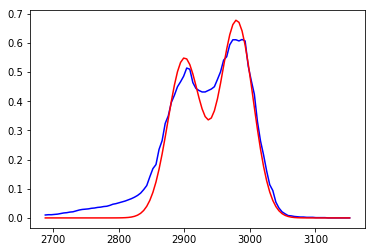

In [16]:
guess = [0.545, 0.675, 2900, 2980, 25, 25]
y_guess = two_gaussians(guess, x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'b')
ax.plot(x_peak, y_guess, 'r')

 We can use the same loss function as before to optimize the other parameters:

In [17]:
def g(lamda, x=x_peak, y=y_peak, m=2):
    return gaussian_loss(lamda, x, y, m)

result = minimize(g, guess, method='BFGS')
result

      fun: 0.0003472560734252687
 hess_inv: array([[ 7.06131339e+00,  1.32015580e+00,  2.02380230e+02,
         1.14148647e+02, -2.40727490e+02, -1.88763946e+02],
       [ 1.32015580e+00,  2.62539867e+01, -2.23167548e+03,
        -1.21555161e+03, -2.12368258e+03,  5.05422778e+02],
       [ 2.02380230e+02, -2.23167548e+03,  3.10111804e+05,
         1.57436153e+05,  2.28256174e+05, -1.01406914e+05],
       [ 1.14148647e+02, -1.21555161e+03,  1.57436153e+05,
         1.05767010e+05,  1.34286069e+05, -5.54776508e+04],
       [-2.40727490e+02, -2.12368258e+03,  2.28256174e+05,
         1.34286069e+05,  2.48853050e+05, -7.83859363e+04],
       [-1.88763946e+02,  5.05422778e+02, -1.01406914e+05,
        -5.54776508e+04, -7.83859363e+04,  5.66555361e+04]])
      jac: array([ 3.42427666e-06, -2.04337994e-07, -7.09405867e-09, -9.84437065e-08,
        1.01063051e-07,  5.09317033e-09])
  message: 'Optimization terminated successfully.'
     nfev: 672
      nit: 79
     njev: 84
   status: 0
  succ

It looks successful! Let's see how well it worked:

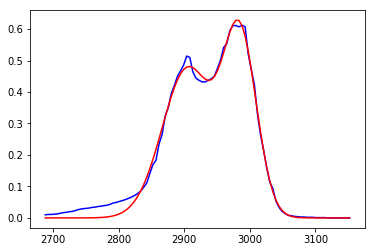

In [18]:
fitted = result.x
y_fitted = two_gaussians(fitted, x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'b')
ax.plot(x_peak, y_fitted, 'r')

This looks much better! 

We can also add constraints to the loss function. For example, we might expect that the peak width (standard deviation) should be similar for both peaks. We can enforce this by adding an additional term to the loss function:

      fun: 0.0005425736558171898
 hess_inv: array([[ 7.29406267e+00,  1.66690044e+00,  1.66723252e+02,
         9.73508763e+01, -2.07904190e+02, -2.07882416e+02],
       [ 1.66690044e+00,  7.23778080e+00, -6.31573103e+01,
        -5.85153311e+01, -2.08918747e+02, -2.08897266e+02],
       [ 1.66723252e+02, -6.31573103e+01,  5.07937975e+04,
         1.21496944e+04, -7.76852567e+03, -7.76870884e+03],
       [ 9.73508763e+01, -5.85153311e+01,  1.21496944e+04,
         2.20237169e+04,  6.42763677e+01,  6.43397043e+01],
       [-2.07904190e+02, -2.08918747e+02, -7.76852567e+03,
         6.42763677e+01,  1.61044075e+04,  1.61039659e+04],
       [-2.07882416e+02, -2.08897266e+02, -7.76870884e+03,
         6.43397043e+01,  1.61039659e+04,  1.61041109e+04]])
      jac: array([-7.10971653e-06,  2.52791506e-06, -2.78574589e-07, -1.17989839e-06,
       -1.37514144e-06,  1.59677438e-06])
  message: 'Optimization terminated successfully.'
     nfev: 472
      nit: 55
     njev: 59
   status: 0
  succ

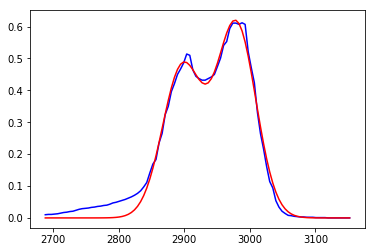

In [19]:
def g_simwidth(lamda, x=x_peak, y=y_peak, N=2):
    return gaussian_loss(lamda, x, y, N) + (lamda[-2] - lamda[-1])**2

result = minimize(g_simwidth, guess, method='BFGS')
fitted = result.x
y_fitted = two_gaussians(fitted, x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'b')
ax.plot(x_peak, y_fitted, 'r')
result

We can see that the fit quality is similar, but now the peak widths are nearly identical. However, they are not exactly the same, since the loss function constraint is "soft" -- the peak widths will deviate if it makes the fit much better.

### Discussion: How would you create a loss function that ensures that all weights $w_i$ are positive?